# Snow depth time series

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os

In [2]:
# https://www.w3schools.com/python/python_classes.asp

class Site:
  def __init__(self, name, long_name, location, lat, lon, elevation, period, start, stop, period_used, run):
    self.name = name
    self.long_name = long_name
    self.location = location
    self.lat = lat
    self.lon = lon
    self.elevation = elevation
    self.period = period
    self.start = start
    self.stop = stop
    self.period_used = period_used
    self.run = run

exps = [
    'DEF',
    # 'BUG_CORRECT',
    # 'BUG_CORRECT_TSNBT_OP1',
    # 'BUG_CORRECT_TSNBT_OP1_EZERO',
    # 'PHYS_ALL_SUBLI_CORRECT',
    # 'PHYS_ALL_SUBLI_v2',
    # 'PHYS_ALL_SUBLI_CORRECT_COMPAC',
    # 'PHYS_ALL_SUBLI_v2_COMPAC_v1',
    # 'PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne', # Best without TVC (COMPACT_2.5)
    # 'PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne', # best with TVC

]

# SnowMIP
cdp = Site('cdp', 'Col de Porte, France', '45.30°N, 5.77°E', 45.30, 5.77, '1325 m', 
           '1 October 1994 to 30 September 2014', '1994-10-01', '2014-09-30', slice('1994-10-01', '2014-09-30'), exps)

rme = Site('rme', 'Reynolds Mountain East, Idaho, USA', '43.19°N, 116.78°W', 43.19, -116.78, '2060 m', 
           '1 October 1988 to 30 September 2008', '1988-10-01', '2008-09-30', slice('1988-10-01', '2008-09-30'), exps)

snb = Site('snb', 'Senator Beck, Colorado, US', '37.91°N, 107.73°W', 37.91, -107.73, '3714 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

swa = Site('swa', 'Swamp Angel, Colorado, USA', '37.91°N, 107.71°W', 37.91, -107.71, '3371 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

sap = Site('sap', 'Sapporo, Japan', '43.08°N, 141.34°E', 43.08, 141.34, '15 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

sod = Site('sod', 'Sodankylä, Finland', '67.37°N, 26.63°E', 67.37, 26.63, '179 m', 
           '1 October 2007 to 30 September 2014', '2007-10-01', '2014-09-30', slice('2007-10-01', '2014-09-30'), exps)

wfj = Site('wfj', 'Weissfluhjoch, Switzerland', '46.83°N, 9.81°E', 46.83, 9.81, '2540 m', 
           '1 September 1996 to 31 August 2016', '1996-10-01', '2016-08-31', slice('1996-10-01', '2016-08-31'), exps)

# Arctic 
byl = Site('byl', 'Bylot Island, Canadian high Arctic', '73.15°N, 80.00°W', 73.15, -80.00, '25 m', 
           '11 July 2013 to 25 June 2019', '2013-07-11', '2019-06-25', slice('2014-07-11', '2019-06-25'), 
           [
               'peat_DEF',
               # 'peat_BUG_CORRECT',
               # 'peat_BUG_CORRECT_TSNBT_OP1',
               # 'peat_BUG_CORRECT_TSNBT_OP1_EZERO',
               # 'peat_PHYS_ALL_SUBLI_CORRECT',
               # 'peat_PHYS_ALL_SUBLI_v2',
               # 'peat_PHYS_ALL_SUBLI_CORRECT_COMPAC',
               # 'peat_PHYS_ALL_SUBLI_v2_COMPAC_v1',
               # 'peat_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne',
               # 'peat_PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne',
           ])

umt = Site('umt', 'Umiujaq TUNDRA, northeastern Canada', '56.55877°N, 76.48234°W', 56.55877, -76.48234, '132 m', 
           '28 Sept 2012 to 15 October 2021', '2012-09-28', '2021-10-15', slice('2016-09-01', '2021-08-31'), 
           [
               'DEF',
               # 'BUG_CORRECT',
               # 'BUG_CORRECT_TSNBT_OP1',
               # 'BUG_CORRECT_TSNBT_OP1_EZERO',
               # 'PHYS_ALL_SUBLI_CORRECT',
               # 'PHYS_ALL_SUBLI_v2',
               # 'PHYS_ALL_SUBLI_CORRECT_COMPAC',
               # 'PHYS_ALL_SUBLI_v2_COMPAC_v1',
               # 'PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne',
               # 'PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne',
           ])


tvc = Site('tvc', 'Trail Valley Creak, northwestern Canada', '68.74617°N, 133.50171°W', 68.74617, -133.50171, '85 m', 
           '01 Oct 2017 to 30 Sept 2019', '2017-10-01', '2019-09-30', slice('2017-10-01', '2019-09-30'), 
           [
               '1peat_2xSnowf_DEF',
               # '1peat_2xSnowfBUG_CORRECT',
               # '1peat_2xSnowfBUG_CORRECT_TSNBT_OP1',
               # '1peat_2xSnowf_BUG_CORRECT_TSNBT_OP1_EZERO',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_CORRECT',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_v2',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_CORRECT_COMPAC',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_v2_COMPAC_v1',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne',
           ])

# umf = Site('umf', 'Umiujaq FOREST, northeastern Canada', '56.55308°N, 76.47258°W', 56.55308, -76.47258, '82 m', 
#            '26 Nov 2015 to 19 October 2021', '2015-11-26', '2021-10-19', slice('2018-09-01', '2021-08-31'), 
#            ['Ref', 'EZERO'])


In [3]:
SnowMIP_sites = [cdp, rme, snb, swa, sap, sod, wfj]
# SnowMIP_sites = [cdp, rme, snb, sap, sod, wfj]
SnowArctic_sites = [byl, umt, tvc]

path_SnowMIP = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'
path_SnowArctic = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'
path_Paul = '/home/lalandmi/Dropbox/data/SnowMIP/Paul/CLASS_Results'

ds_d_SnowMIP_list = []
for i, exp in enumerate(exps):
    paths_SnowMIP = [path_SnowMIP+site.name+'/'+'run_'+exp for site in SnowMIP_sites]
    # Change the syntax as the ref run is not necessarily having the same name for all sites
    paths_SnowArctic = [path_SnowArctic+site.name+'/'+'run_'+site.run[i] for site in SnowArctic_sites]
    paths = paths_SnowMIP + paths_SnowArctic
    ds_d_SnowMIP_list.append([xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths])


# ds_d_Paul_list = []
# for site in SnowMIP_sites:
#     df_Paul = pd.read_csv(path_Paul+'/CLASS_sv_REF_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.txt', delim_whitespace=True)
#     df_Paul.index = pd.to_datetime(df_Paul[['year', 'month', 'day', 'hour']]).values
#     df_Paul= df_Paul.drop(columns=['year', 'month', 'day', 'hour'])
#     df_Paul.albsn = df_Paul.albsn.replace({0 : np.nan})
#     df_Paul.albs = df_Paul.albs.replace({0 : np.nan})
#     df_Paul.tsn = df_Paul.tsn.replace({-999 : np.nan})
#     df_Paul.tsns = df_Paul.tsns.replace({-999 : np.nan})
#     ds_Paul_h = df_Paul.to_xarray()
#     ds_Paul_h = ds_Paul_h.rename({'index': 'time'})
#     ds_Paul_d = ds_Paul_h.resample(time='D').mean().load()
#     ds_Paul_d = ds_Paul_d.assign_coords(layer=[0.05 , 0.225, 2.225]) # center of Paul's soil layers (DELZ = [0.1, 0.25, 3.75])
    

#     # Combine the Soil temperature in one variable
#     ds_Paul_d = ds_Paul_d.assign(
#         tsl=(('layer', 'time'), [
#             list(ds_Paul_d['tsl:1'].values),
#             list(ds_Paul_d['tsl:2'].values),
#             list(ds_Paul_d['tsl:3'].values),
#         ])
#     )
        
#     ds_d_Paul_list.append(ds_Paul_d)

## Set soil levels

In [4]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/cdp"
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [5]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [6]:
for i, exp in enumerate(exps):
    for j in range(len(SnowMIP_sites+SnowArctic_sites)):
        ds_d_SnowMIP_list[i][j] = assign_center_depth(ds_d_SnowMIP_list[i][j], rsfile)

## Convert noleap year cftime to datetime

In [7]:
for i in range(len(tvc.run)):
    ds_d_SnowMIP_list[i][-1]['time'] = pd.to_datetime(ds_d_SnowMIP_list[i][-1].indexes['time'].to_datetimeindex())
    ds_d_SnowMIP_list[i][-1] = ds_d_SnowMIP_list[i][-1].reindex(
        time=pd.date_range(
            ds_d_SnowMIP_list[i][-1]['time'][0].values, 
            ds_d_SnowMIP_list[i][-1]['time'][-1].values
        )
    )

/tmp/ipykernel_74155/2435143374.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_d_SnowMIP_list[i][-1]['time'] = pd.to_datetime(ds_d_SnowMIP_list[i][-1].indexes['time'].to_datetimeindex())


## Compare with obs

In [11]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_d_Obs_list = []
for site in SnowMIP_sites:
    ds_h_eval_menard2019 = xr.open_dataset(path_menard2019+'/obs_insitu_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.nc')
    ds_d_eval_menard2019 = ds_h_eval_menard2019.resample(time='D').mean().load()
    ds_d_Obs_list.append(ds_d_eval_menard2019)

In [12]:
path_obs_byl = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
path_obs_umt = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'
# path_obs_umf = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'
path_obs_tvc = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/TVC/TVCSnowCLM/TVCMetData'

# path_obs_list = [path_obs_byl, path_obs_umt, path_obs_umf]
path_obs_list = [path_obs_byl, path_obs_umt, path_obs_tvc]
for site, path in zip(SnowArctic_sites, path_obs_list):
    ds_h_obs = xr.open_dataset(path+'/obs_insitu_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.nc').load()
    if site.name == 'byl':
        ds_h_obs['albs'] = ds_h_obs.albs.where(ds_h_obs.flag_albs_ERA5 == 0).where(ds_h_obs.albs < 1) # to avoid > 1 albedo values
    if site.name == 'umt':
        ds_h_obs = ds_h_obs.mean(dim='veg') # average over lichen and lowshrub area (tsl)
    if site.name in ['tvc']:
        ds_h_obs['snd_auto'] = ds_h_obs.snd_auto/100
        ds_h_obs = ds_h_obs.rename({'albedo': 'albs', 'swc': 'mrsll'})
    # Remove albs for Arctic sites (wrong values)
    if site.name in ['byl', 'umt', 'tvc']:
        ds_h_obs = ds_h_obs.drop_vars('albs')
        
    ds_d_obs = ds_h_obs.resample(time='D').mean().load()
    ds_d_Obs_list.append(ds_d_obs)

## Merge Arctic and SnowMIP

In [13]:
# ds_d_Obs_list = ds_d_Obs_list + ds_d_Obs_Arctic_list
# ds_d_SnowMIP_list = ds_d_SnowMIP_list + ds_d_SnowArctic_list

### SD

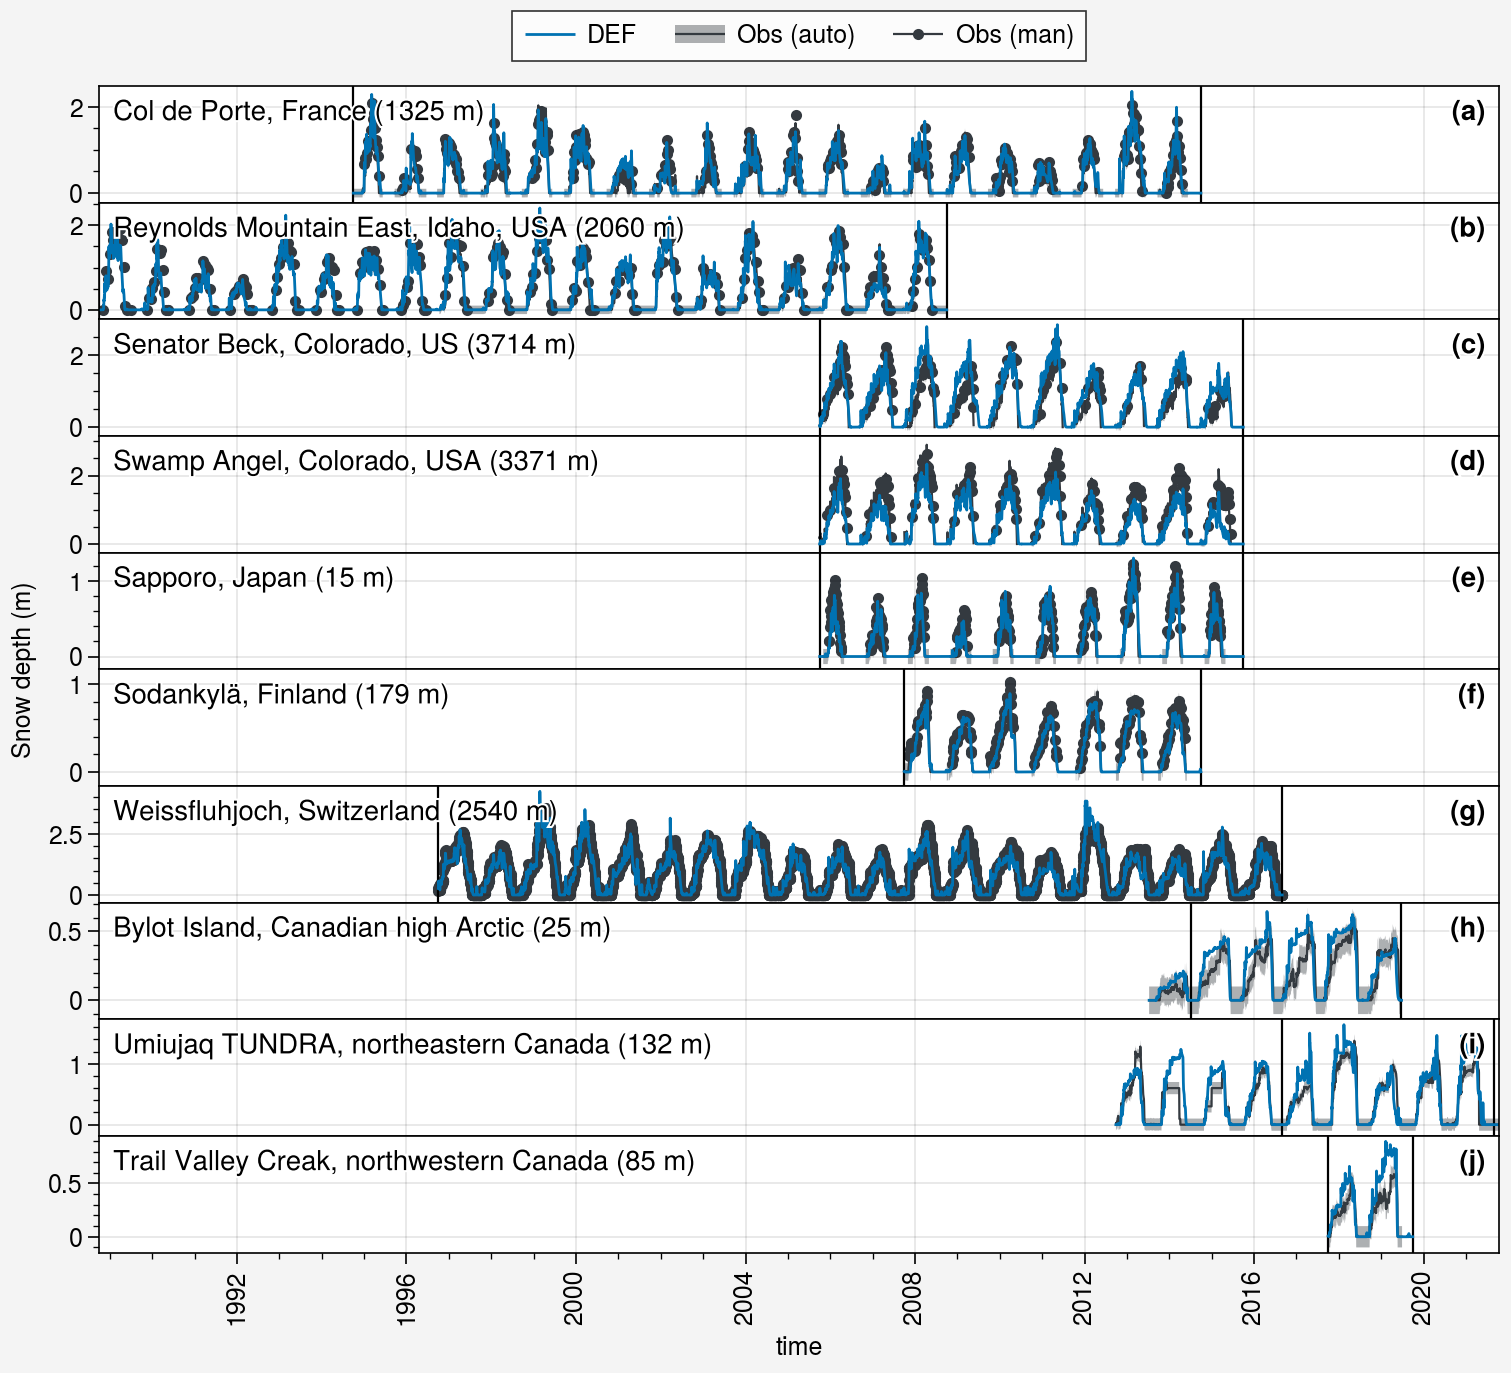

In [17]:
fig, axs = pplt.subplots(nrows=len(SnowMIP_sites+SnowArctic_sites), refaspect=12, refwidth=7, space=0)

color_obs = 'gray8'

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    # Model 
    h_exps = []
    for j, exp in enumerate(exps): 
        h = axs[i].plot(ds_d_SnowMIP_list[j][i].snd.sel(time=slice(site.start, site.stop)), label=exp, lw=1)
        h_exps.append(h)

    # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
    #     h_paul = axs[i].plot(ds_d_Paul_list[i].snd.sel(time=slice(site.start, site.stop)), label='CLASS', color='red9', lw=1)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)).values+0.1, axis=0),
        np.expand_dims(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)).values-0.1, axis=0),), axis=0)
    h_obs_auto = axs[i].plot(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)), shadedata=shadedata, color=color_obs, 
                zorder=0, lw=0.8, label='Obs (auto)')
    
    if 'snd_man' in list(ds_d_Obs_list[i].keys()):
        h_obs_man = axs[i].plot(ds_d_Obs_list[i].snd_man.sel(time=slice(site.start, site.stop)), marker='.', color=color_obs, 
                    zorder=0, lw=0.8, label='Obs (man)')
    
    axs[i].format(ylabel='Snow depth (m)', ultitle=site.long_name+' ('+site.elevation+')')
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[0], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[-1], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    


# axs[4].legend(ncols=5, loc='ll')
# fig.legend(h_exps+h_paul+h_obs_auto+h_obs_man, ncols=2, loc='t')
fig.legend(h_exps+h_obs_auto+h_obs_man, ncols=3, loc='t')

fig.format(abc='(a)', abcloc='ur')

# fig.save('img/snd_ts_v0.jpg')
# fig.save('img/snd_ts_v0.png')
# fig.save('img/snd_ts_v0.pdf')